In [1]:
from graphviz import Digraph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision.all import *
import librosa, librosa.display
from segmentation import segment_cough, compute_SNR
from helper_functions import plot_sample, plot_multiple_samples, plot_spectrum, plot_features
from IPython.display import Audio

# Coughvid Detector

An application to discriminate between cough due to COVID19 or another disease based on a cough audio sample and other anagraphic and symptoms data.

At the core of this logistic are a convoluted neural network (CNN) and a random forest classifier (RFC), which are combined to predict the class label (covid or not). The audio sample is converted to a spectrogram in order to be feeded to the CNN, the prediction of the CNN is then combined with the data (anagraphic and symptoms) of the person in order to have more accurate features to be feed to the RFC, which then does the final prediction. The use of a CNN for this kind of task instead of a RNN should result in a better margin of performance, see: [Rethinking CNN Models for Audio Classification](https://arxiv.org/abs/2007.11154) and [Exploring convolutional, recurrent, and hybrid deep neural networks for speech and music detection in a large audio dataset](https://asmp-eurasipjournals.springeropen.com/articles/10.1186/s13636-019-0152-1)

The dataset and a the segmentation function comes from this paper: [The COUGHVID crowdsourcing dataset, a corpus for the study of large-scale cough analysis algorithms](https://www.nature.com/articles/s41597-021-00937-4), the original dataset of the paper is [here](https://zenodo.org/record/4498364), but for convinience you can find the already converted .wav version here on [Kaggle](https://www.kaggle.com/datasets/nasrulhakim86/coughvid-wav) (the original one uses .ogg and .webm formats. The official repository of the paper is [here](https://c4science.ch/diffusion/10770/)

The general logic scheme behind it is shown in the diagram below.

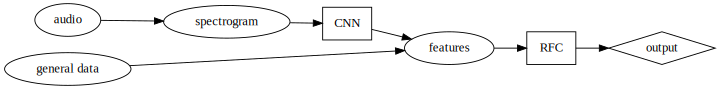

In [2]:
g = Digraph(
    graph_attr={
        'rankdir':'LR',
        'size':'10'
    }
)

with g.subgraph() as s:
    s.attr(rank='same')
    s.node('A', 'audio')
    s.node('D', 'general data')

g.node('S', 'spectrogram')
g.node('C', 'CNN', shape='box')
g.node('R', 'RFC', shape='box')
g.node('F', 'features')
g.node('O', 'output', shape='diamond')

g.edges(['AS', 'SC', 'CF', 'DF', 'FR', 'RO'])

g


## Audio processing

The audio is processed in a simple pipeline which takes the raw sample, segments it through an hysteresis comparator on the signal power, and convert it in a log frequency power spectrogram (using Librosa library).

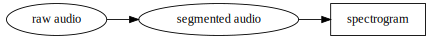

In [3]:
g = Digraph(
    graph_attr={
        'rankdir':'LR',
        'size':'6'
    }
)

g.node('R', 'raw audio')
g.node('S', 'segmented audio')
# g.node('C', 'clean segment')
g.node('G', 'spectrogram', shape='rect')

g.edges(['RS', 'SG'])

g

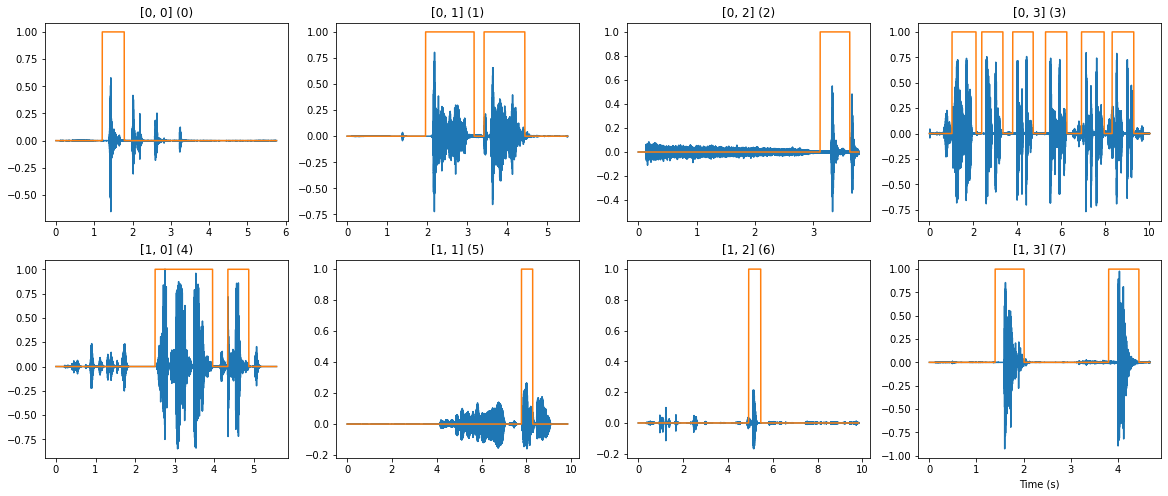

In [4]:
plots = plot_multiple_samples('data/coughvid/', max=8, mask=True)

Cough on avarage has high ratio of lower frequency tones, thus the log frequency power spectrogram should provide a richer feature for the CNN. This is illustrated in the plot of a sample in the picture below.

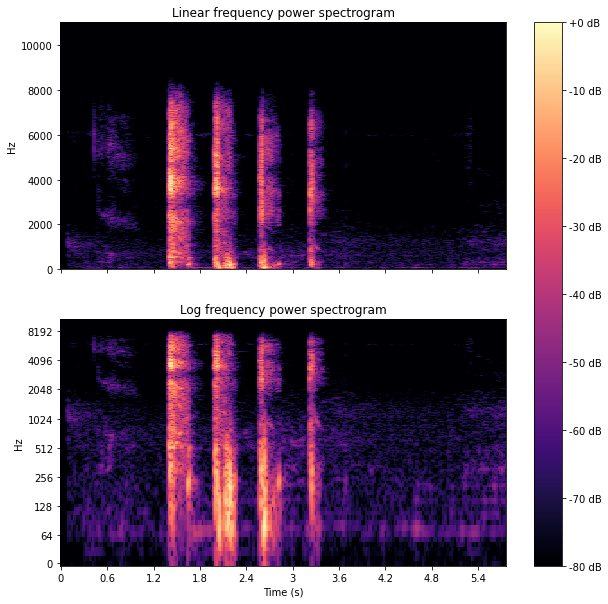

In [5]:
plot_spectrum(plots[0])